In [24]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error
from math import sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [37]:
# Load the dataset
# Source: https://www.kaggle.com/code/grosvenpaul/eda-and-time-series-modeling/data
df = pd.read_csv('candy_production.csv',index_col='observation_date',parse_dates=True)
df.rename(columns={'IPG3113N':'Production'},inplace=True)
df.index_freq='MS' # monthly indexing
df.head()


,Production
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


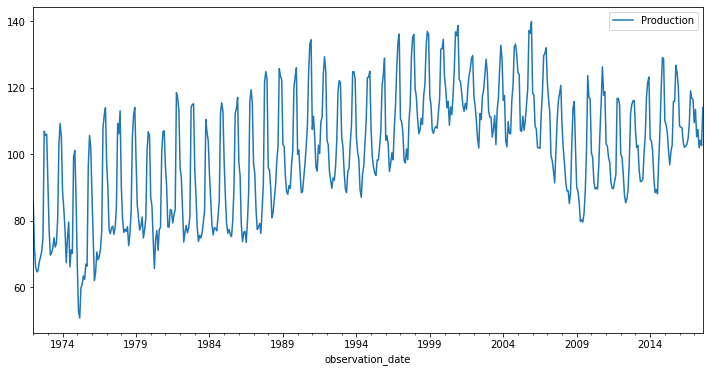

In [38]:
df.plot(figsize=(12,6))

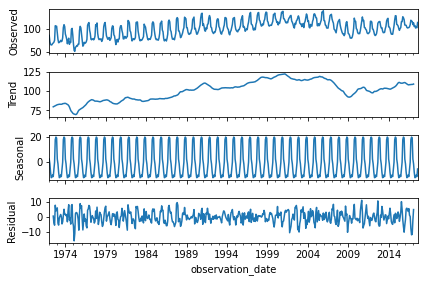

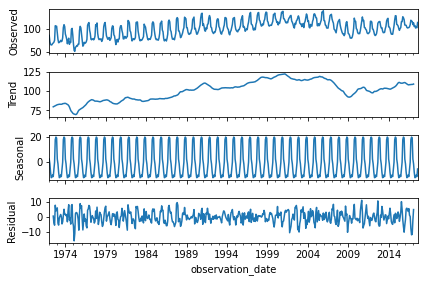

In [41]:
# Decompose to observe different parts of time series     
results = seasonal_decompose(df['Production'])
results.plot()

In [61]:
# Seperate data into train and test samples
train = df.iloc[:536]
test  = df.iloc[536:] # last year

In [62]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test  = scaler.transform(test) 

In [63]:
# Define generator for inputs consistency
n_input    = 12 # month 
n_features = 1
generator  = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [64]:
# Show how generator works
X,y = generator[0]
print(f'Given the Array: \n {X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
 [0.39245953 0.23699667 0.17204055 0.15569928 0.16069108 0.19023512
 0.20587945 0.22598222 0.27314603 0.63038957 0.61545676 0.61961491]
Predict this y: 
 [[0.45526542]]


In [65]:
# Define a model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [66]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [90]:
# Fit the model
model.fit(generator, epochs=20) 

Epoch 1/20
524/524 [==============================] - 5s 9ms/step - loss: 0.0018
Epoch 2/20
524/524 [==============================] - 4s 7ms/step - loss: 0.0018
Epoch 3/20
524/524 [==============================] - 5s 10ms/step - loss: 0.0019
Epoch 4/20
524/524 [==============================] - 4s 7ms/step - loss: 0.0017
Epoch 5/20
524/524 [==============================] - 4s 7ms/step - loss: 0.0017
Epoch 6/20
524/524 [==============================] - 4s 7ms/step - loss: 0.0019
Epoch 7/20
524/524 [==============================] - 4s 7ms/step - loss: 0.0018
Epoch 8/20
524/524 [==============================] - 4s 7ms/step - loss: 0.0017
Epoch 9/20
524/524 [==============================] - 4s 7ms/step - loss: 0.0018
Epoch 10/20
524/524 [==============================] - 4s 8ms/step - loss: 0.0017
Epoch 11/20
524/524 [==============================] - 5s 9ms/step - loss: 0.0018
Epoch 12/20
524/524 [==============================] - 4s 8ms/step - loss: 0.0017
Epoch 13/20
524/524 [===

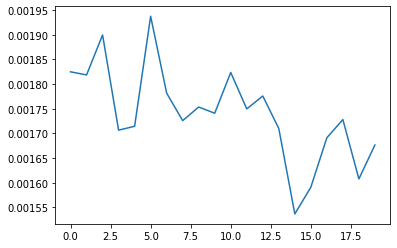

In [91]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [92]:
last_train_batch = scaled_train[-12:] # last year

In [93]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [94]:
model.predict(last_train_batch)

array([[0.6771195]], dtype=float32)

In [95]:
scaled_test[0]

array([0.65717161])

In [96]:
# Make predictions on the testing set
test_predictions = []   # [1,2,3] --> [4] --> [2,3,4] --> [5]

first_eval_batch = scaled_train[-n_input:]
current_batch    = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):

  # get the pred value for the first batch
  current_pred = model.predict(current_batch)[0]

  # append the prediction into the array
  test_predictions.append(current_pred)

  # use the prediction to update the batch and remove the first value
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [97]:
# Since production values are  scaled for processing, inverse the transformation for comparing the original dataset
true_predictions = scaler.inverse_transform(test_predictions)

In [98]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


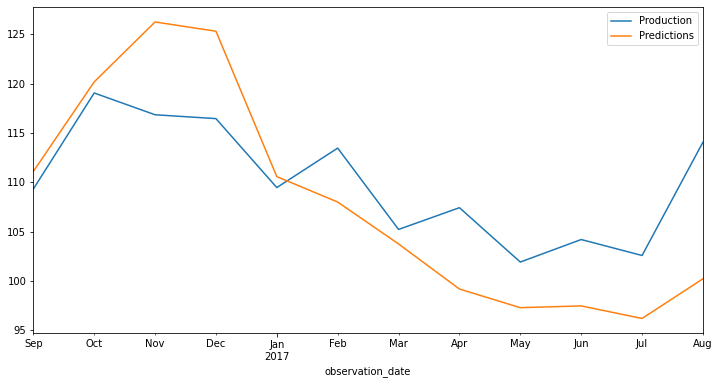

In [99]:
test.plot(figsize=(12,6))

In [100]:
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(rmse)

6.899411898913414
